# Roman Urdu Sentiment Analysis

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/urdustopwords/stopwords.txt
/kaggle/input/urduromansentiment/Roman Urdu DataSet.csv


### **GOAL**
* Train a sentiment classifier (Positive, Negative, Neutral) on a corpus of the provided dataset below. 
* Maximize accuracy of the classifier with a special interest in being able to accurately detect negative sentiment.

### **Data Set Description** 
Classifier model developed below uses a dataset obtained form UCI Machine Learning Repository located <a href="http://archive.ics.uci.edu/ml/datasets/Roman+Urdu+Data+Set">here</a>

This dataset is authored by Zareen Sharf, from Shaheed Zulfiqar Ali Bhutto Institute of Science and Technology (SZABIST). Data set contains sentences in Urdu languate and it is tagged for sentiements either, Positive, Negative, or Neutral.

Sentences in Urdu are written in plain English for word processing rather than native Urdu fonts. Data includes documents from a wide variety of sources, not merely social media, and some of it may be inconsistently
labeled.

### **Plan of Work** 

Sentiment analysis involves the following stages. 

* Loading and cleaning the data
* Exploratory data analysis
* Ommiting stop words or common words
* Creating new features
* Plotting most frequently used words
* Vectorizing sentences to build a matrix
* Training and testing the machine learning model
* Evaluating the machine learning model accuracy

In [2]:
# Loading required python packages and libraries
import nltk
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import string
import pickle
import random
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from wordcloud import WordCloud,STOPWORDS

stopwords = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer()

In [3]:
# Load the csv file using Pandas and print first 5 lines
data = pd.read_csv("../input/urduromansentiment/Roman Urdu DataSet.csv",header=None)
data.head()

,0,1,2
0,Sai kha ya her kisi kay bus ki bat nhi hai lak...,Positive,NaN
1,sahi bt h,Positive,NaN
2,"Kya bt hai,",Positive,NaN
3,Wah je wah,Positive,NaN
4,Are wha kaya bat hai,Positive,NaN


### **Data Preprocessing**

In this step, data is preprocessed or cleaned for missing column names, incorrect values of sentiments, null values present in the text body. 

In [4]:
# Adding column names
data.columns =['body_text','sentiment','unknown']

In [5]:
# Print unique values in column 1 and 2
print ('Unique values of the sentiments are', data.sentiment.unique())
print ('Unique values of the unknonwn column are', data.unknown.unique())

Unique values of the sentiments are ['Positive' 'Neutral' 'Negative' 'Neative']
Unique values of the unknonwn column are [nan '----------------' '----------' '-------' '------' '9090' 'till here']


In [6]:
# 'Neative' sentiment will be most likely Negative, so it is replaced accordingly. 
data[data['sentiment']=='Neative']='Negative'

In [7]:
# Verify we replaced all the 'Neative'
print ('Unique values of the sentiments are', data.sentiment.unique())

Unique values of the sentiments are ['Positive' 'Neutral' 'Negative']


In [8]:
# Checking Null values in the data
data.isna().sum()

body_text        1
sentiment        0
unknown      20221
dtype: int64

In [9]:
# Dropping the text body row which has a null value
data = data.dropna(subset=['body_text'])

In [10]:
# Last column can be dropped as it does not contain any useful information. Here axis=1, means column. 
data = data.drop('unknown', axis=1)

In [11]:
data.head()

,body_text,sentiment
0,Sai kha ya her kisi kay bus ki bat nhi hai lak...,Positive
1,sahi bt h,Positive
2,"Kya bt hai,",Positive
3,Wah je wah,Positive
4,Are wha kaya bat hai,Positive


In [12]:
data.describe()

,body_text,sentiment
count,20228,20228
unique,19664,3
top,Good,Neutral
freq,23,8928


### **Data Exploration**

From the data of sentiments, it looks like it is not balanced. There are more neutral comments than positive and negative comments. When the class distribution is unbalanced, accuracy is considered a poor choice of evaluation of classifier. This is due the fact that, it gives high scores to models which just predict the most frequent class.

Number of sentiments in each category are as below
Neutral     8928
Positive    6013
Negative    5287
Name: sentiment, dtype: int64

Perecentage sentiments in each category are as below
Neutral     44.136840
Positive    29.726122
Negative    26.137038
Name: sentiment, dtype: float64


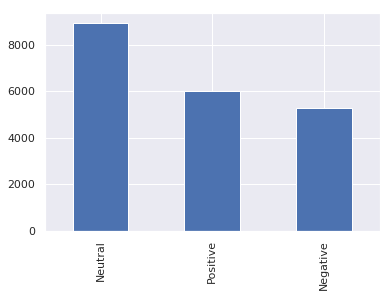

In [13]:
print ('Number of sentiments in each category are as below')
print (data.sentiment.value_counts())

print ('\nPerecentage sentiments in each category are as below')
print (data.sentiment.value_counts()/data.shape[0]*100)

data.sentiment.value_counts().plot(kind='bar')

In [14]:
# Dropping neutral sentiment sentences. 
data = data[data.sentiment != 'Neutral']

In [15]:
data = data.reset_index(drop=True)

In [16]:
data.head()

,body_text,sentiment
0,Sai kha ya her kisi kay bus ki bat nhi hai lak...,Positive
1,sahi bt h,Positive
2,"Kya bt hai,",Positive
3,Wah je wah,Positive
4,Are wha kaya bat hai,Positive


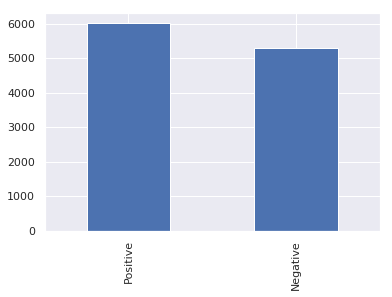

In [17]:
data.sentiment.value_counts().plot(kind='bar')

In [18]:
data.describe()

,body_text,sentiment
count,11300,11300
unique,11098,2
top,Good,Positive
freq,23,6013


### **Data Cleaning**

* Make all words lowercase
* Replace any stopwords

**Frequently Used Words**

It is important to check for frequency of words. This helps to identify any missing stopwods or its variation in spelling. Stopwords are then updated if required. 

* First we will create a long list containing all words in the text provided. 
* Unique words are then counted and words with significant number of occurances are reported. 
* Stopwords list is updated.
* Remaining high frequency words are then visually inspected using wordcloud by each sentiment.

From words in worldcloud of each sentiment, it can be noted that there is some overlapp of words between three classes. Though most of the words are different and correct. 

In [19]:
text_wordcloud = " ".join(word.lower() for word in data.body_text)
print ('There are total {} words in text provided.'.format(len(text_wordcloud)))

There are total 932615 words in text provided.


In [20]:
def freq(str): 
  
    # Break the string into list of words  
    str = str.split()          
    str2 = [] 
  
    # Loop till string values present in list str 
    for i in str:              
  
        # Checking for the duplicacy 
        if i not in str2: 
  
            # Append value in str2 
            str2.append(i)  
              
    for i in range(0, len(str2)): 
        if(str.count(str2[i])>100): 
            print('Frequency of word,', str2[i],':', str.count(str2[i]))
            
freq(text_wordcloud)

Frequency of word, ya : 335
Frequency of word, kisi : 236
Frequency of word, kay : 479
Frequency of word, ki : 4030
Frequency of word, bat : 141
Frequency of word, nhi : 243
Frequency of word, hai : 2274
Frequency of word, main : 606
Frequency of word, aur : 2236
Frequency of word, sirf : 205
Frequency of word, say : 274
Frequency of word, h : 339
Frequency of word, kya : 169
Frequency of word, hai, : 172
Frequency of word, baat : 228
Frequency of word, allah : 894
Frequency of word, sab : 285
Frequency of word, pe : 167
Frequency of word, or : 766
Frequency of word, ko : 2543
Frequency of word, de : 168
Frequency of word, ameen : 249
Frequency of word, ka : 2446
Frequency of word, naam : 121
Frequency of word, wo : 676
Frequency of word, he : 564
Frequency of word, bari : 117
Frequency of word, mere : 146
Frequency of word, tu : 298
Frequency of word, hy : 449
Frequency of word, is : 1128
Frequency of word, mulk : 137
Frequency of word, k : 2004
Frequency of word, pr : 176
Frequency o

In [21]:
UrduStopWordList = [line.rstrip('\n') for line in open('../input/urdustopwords/stopwords.txt')]

print (UrduStopWordList)

['nahi', 'nhi', 'nh', 'ney', 'nai', 'nay', 'chi', 'ni', 'na', 'k', 'ye', 'to', 'hai', 'kisi', 'sy', 'hain', 'or', 'tak', 'ek', 'aik', 'kiya', 'liya', 'diya', 'dete', 'unhon', 'unhen', 'sey', 'kiye', 'mujhe', 'mjhe', 'bana', 'hue', 'aur', 'wo', 'woh', 'ai', 'aisa', 'waisa', 'mera', 'mere', 'mery', 'meri', 'muzhe', 'mai', 'hum', 'khud', 'acha', 'per', 'har', 'tag', 'bat', 'baat', 'pr', 'he', 'hamara', 'jahan', 'tumhara', 'apka', 'apke', 'wale', 'walon', 'lekin', 'lakin', 'kitna', 'ke', 'hota', 'hon', 'kab', 'kb', 'kabhi', 'sirf', 'hoti', 'hote', 'magar', 'app', 'agar', 'agr', 'pta', 'jab', 'inhe', 'inho', 'in', 'sath', 'esa', 'kaha', 'key', 'kahan', 'jis', 'kia', 'ayi', 'hy', 'main', 'mein', 'me', 'hein', 'hn', 'ki', 'tha', 'ta', 'koi', 'ko', 'woh ', 'bhi', 'yeh', 'raha', 'rha', 'hota', 'ho', 'ga', 'ka', 'leye', 'lye', 'kr', 'kar', 'kry', 'ker', 'lye', 'liye', 'liya', 'hotay', 'waisay', 'gya', 'gaya', 'gae', 'kch', 'kuch', 'ab', 'thy', 'thay', 'houn', 'hain', 'bad', 'baad', 'hai', 'ha', 

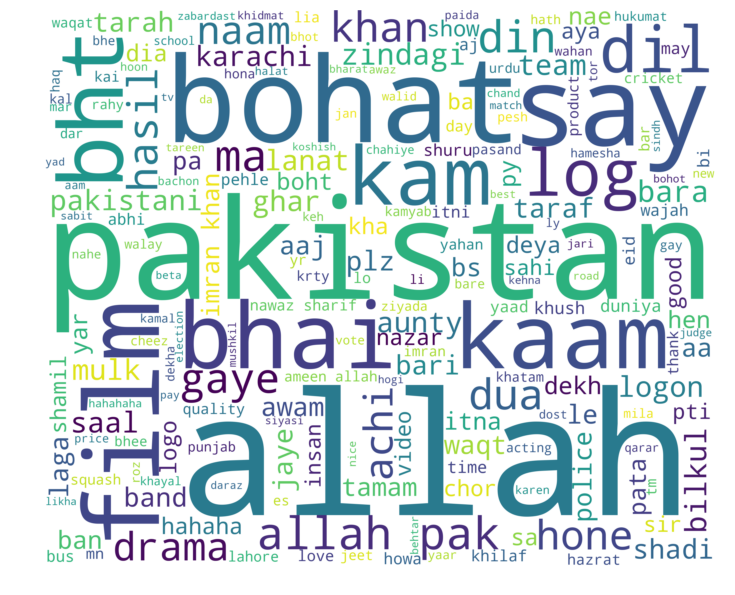

In [22]:
stopwords_with_urdu = set(STOPWORDS)
stopwords_with_urdu.update(UrduStopWordList)


wordcloud = WordCloud(stopwords=stopwords_with_urdu,
                      background_color='white',
                      width=3000,
                      height=2500
                     ).generate(text_wordcloud)
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis('off')
plt.show()

In [23]:
neg_text_wordcloud = " ".join(word.lower() for word in data[data['sentiment']=='Negative']['body_text'])
print ('There are total {} words in sentences with negative sentiments.'.format(len(neg_text_wordcloud)))

There are total 420977 words in sentences with negative sentiments.


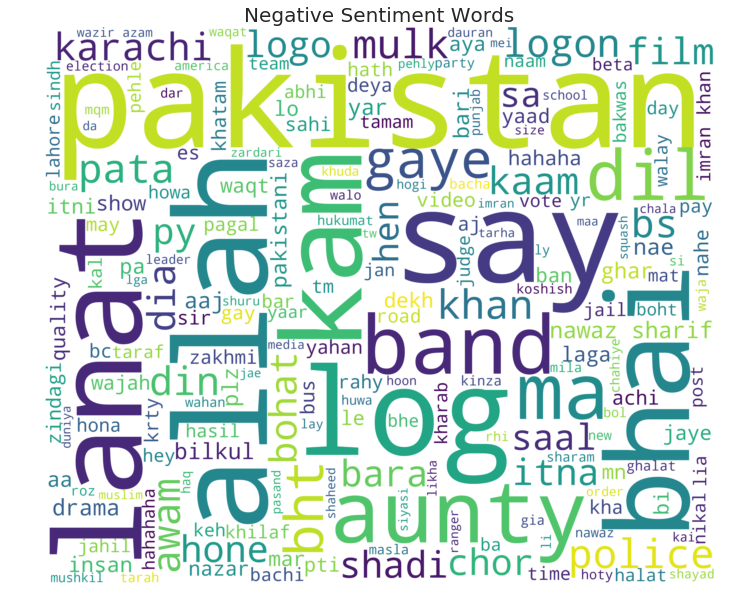

In [24]:
# Plotting Plotting words in setences with negative sentiment
wordcloud = WordCloud(stopwords=stopwords_with_urdu,
                      background_color='white',
                      width=3000,
                      height=2500
                     ).generate(neg_text_wordcloud)
plt.figure(1,figsize=(12, 12))
plt.title('Negative Sentiment Words',fontsize = 20)
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis('off')
plt.show()

In [25]:
pos_text_wordcloud = " ".join(word.lower() for word in data[data['sentiment']=='Positive']['body_text'])
print ('There are total {} words in text with positive sentements.'.format(len(pos_text_wordcloud)))

There are total 511637 words in text with positive sentements.


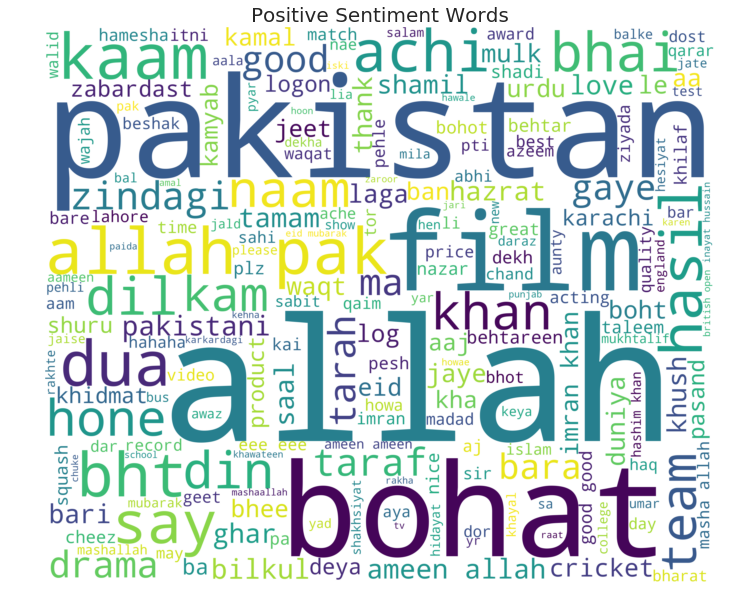

In [26]:
# Plotting words in positive sentiment sentences

wordcloud = WordCloud(stopwords=stopwords_with_urdu,
                      background_color='white',
                      width=3000,
                      height=2500
                     ).generate(pos_text_wordcloud)
plt.figure(1,figsize=(12, 12))
plt.title('Positive Sentiment Words',fontsize = 20)
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis('off')
plt.show()

## **Feature Engineering**

In this step following new features are introduced.

* Length of text field
* Number of punctuations in the sentence body 
* TFIDF vectorization used to create vector of words

It can be noted that length of the sentence changes for different clasess. Punctuation count variation between different class is not significant. Emoji count is small but helps in improving accuracy slightly. 

In [27]:
data['body_len'] = data['body_text'].apply(lambda x: len(x) - x.count(" "))

punct = string.punctuation

def count_punct(text):
    count = sum([1 for char in text if char in punct])
    return count

data['punct_count'] = data['body_text'].apply(lambda x: count_punct(x))

data.head()

,body_text,sentiment,body_len,punct_count
0,Sai kha ya her kisi kay bus ki bat nhi hai lak...,Positive,73,0
1,sahi bt h,Positive,7,0
2,"Kya bt hai,",Positive,9,1
3,Wah je wah,Positive,8,0
4,Are wha kaya bat hai,Positive,16,0


In [28]:
#Counting emojis in sentences
emoji = ['😝','😂','😃','😄','😅','😒','😉','😍','😑','😥','🤣','💃','👫','😛','😉','♥️','😍','🙈','👊','🤪','😘','🤭','💔']

def count_emoji(text):
    count = sum([1 for char in text if char in emoji])
    return count

data['emoji_count'] = data['body_text'].apply(lambda x: count_emoji(x))

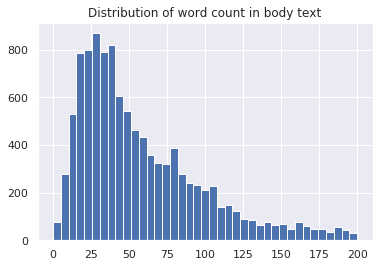

In [29]:
bins = np.linspace(0, 200, 40)

plt.hist(data['body_len'], bins)
plt.title('Distribution of word count in body text')

plt.show()

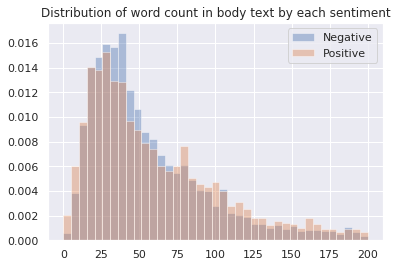

In [30]:
bins = np.linspace(0, 200, 40)
plt.hist(data[data['sentiment']=='Negative']['body_len'], bins, density = True, alpha =0.4, label = 'Negative')
plt.hist(data[data['sentiment']=='Positive']['body_len'], bins, density = True, alpha =0.4, label = 'Positive')
plt.legend(loc='upper right')
plt.title('Distribution of word count in body text by each sentiment')
plt.show()

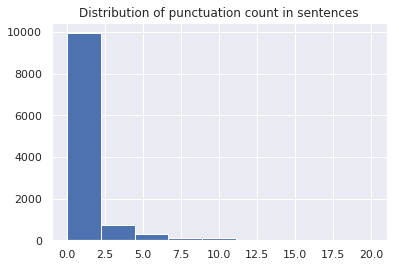

In [31]:
bins = np.linspace(0, 20, 10)

plt.hist(data['punct_count'],bins)
plt.title('Distribution of punctuation count in sentences')

plt.show()

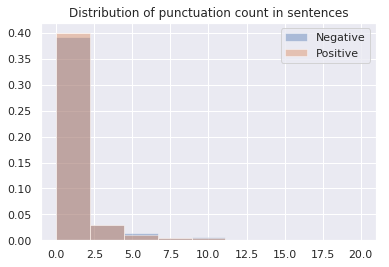

In [32]:
bins = np.linspace(0, 20, 10)
plt.hist(data[data['sentiment']=='Negative']['punct_count'], bins, density = True, alpha =0.4, label = 'Negative')
plt.hist(data[data['sentiment']=='Positive']['punct_count'], bins, density = True, alpha =0.4, label = 'Positive')
plt.legend(loc='upper right')
plt.title('Distribution of punctuation count in sentences')
plt.show()

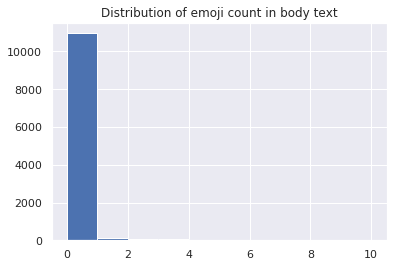

In [33]:
plt.hist(data['emoji_count'])
plt.title('Distribution of emoji count in body text')
plt.show()

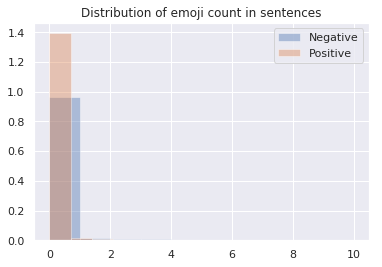

In [34]:
bins = np.linspace(0, 20, 10)
plt.hist(data[data['sentiment']=='Negative']['emoji_count'], density = True, alpha =0.4, label = 'Negative')
plt.hist(data[data['sentiment']=='Positive']['emoji_count'], density = True, alpha =0.4, label = 'Positive')
plt.legend(loc='upper right')
plt.title('Distribution of emoji count in sentences')
plt.show()

In [35]:
data.head()

,body_text,sentiment,body_len,punct_count,emoji_count
0,Sai kha ya her kisi kay bus ki bat nhi hai lak...,Positive,73,0,0
1,sahi bt h,Positive,7,0,0
2,"Kya bt hai,",Positive,9,1,0
3,Wah je wah,Positive,8,0,0
4,Are wha kaya bat hai,Positive,16,0,0


### Split into train/test


In [36]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(data[['body_text', 'body_len', 'punct_count','emoji_count']],\
                                                    data['sentiment'], test_size=0.2,random_state=42,\
                                                    stratify=data['sentiment'])

In [37]:
y_train.describe()

count         9040
unique           2
top       Positive
freq          4810
Name: sentiment, dtype: object

In [38]:
def clean_text(text):
    #Change each character to lowercase and avoid any punctuation. Finally join word back. 
    text = "".join([char.lower() for char in text if char not in string.punctuation])
    
    # Use non word characters to split the sentence
    tokens = re.split('\W+', text)

    # Remove the stop words - commonly used words such as I, we, you, am, is etc in Urdu language 
    # that do not contribute to sentiment. 
    text = [word for word in tokens if word not in stopwords_with_urdu]
    return text

data_clean = data['body_text'].apply(lambda x: clean_text(x))
pd.set_option('max_colwidth', 800)
data_clean.head(10)

0                                         [sai, kha, bus, hal, kal, bi, aj, aj, bi, aus, say, bus]
1                                                                                       [sahi, bt]
2                                                                                             [bt]
3                                                                                   [wah, je, wah]
4                                                                                      [wha, kaya]
5                                                                                     [wah, likhi]
6                                                                       [wha, itni, sari, khubiya]
7                                                                                  [itni, khubiya]
8                                                     [allah, rehm, farma, zalimo, hidayat, ameen]
9    [please, everyone, allah, swt, naam, hamesha, bary, lawzo, likha, kary, zaat, say, bari, hey]
Name: body

### Vectorize text

Sentiment text classifier can not directly classify text. Machine learning models mainly expect text to be tranformed into a numerical form. 

This is done by converting sentences into vector of numbers. Each column indicates a word and frequency of words. This process is a way of feature extraction and termed as Bag of Words. It is called bag of words, because it does not track which words comes after another (order of words). 

In [39]:
# Function clean_text used to clean the sentiment data before vectorizing to remove stop words and punctuations. 
# min_df is the minimum numbers of documents a word must be present in to be kept.
# norm is set to l2, to ensure all our feature vectors have a euclidian norm of 1 with norm='l2', but not set
# ngram_range is set to (1, 2) to consider both unigrams and bigrams  

tfidf_vect = TfidfVectorizer(analyzer=clean_text,ngram_range=(1, 2)) 
tfidf_vect_fit = tfidf_vect.fit(X_train['body_text'])

tfidf_train = tfidf_vect_fit.transform(X_train['body_text'])
tfidf_test = tfidf_vect_fit.transform(X_test['body_text'])

In [40]:
X_train_vect = pd.concat([X_train[['body_len', 'punct_count','emoji_count']].reset_index(drop=True), 
           pd.DataFrame(tfidf_train.toarray())], axis=1)
X_test_vect = pd.concat([X_test[['body_len', 'punct_count','emoji_count']].reset_index(drop=True), 
           pd.DataFrame(tfidf_test.toarray())], axis=1)

X_train_vect.head()

,body_len,punct_count,emoji_count,0,1,2,3,4,5,6,...,21913,21914,21915,21916,21917,21918,21919,21920,21921,21922
0,44,0,0,0.123794,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,13,5,0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,28,1,0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,125,2,0,0.064612,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,76,0,0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
X_train_vect.shape

(9040, 21926)

### Building Machine Learning Models

In [42]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_recall_fscore_support as score, roc_auc_score
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from mlxtend.plotting import plot_confusion_matrix

import time

In [43]:
# Grid search on Random Forest Classifier
def train_RF(n_est,depth):
    rf = RandomForestClassifier(n_estimators=n_est, max_depth=depth, n_jobs=-1,class_weight="balanced")
    rf_model = rf.fit(X_train_vect, y_train)
    y_pred = rf_model.predict(X_test_vect)
    precision, recall, fscore, train_support = score(y_test, y_pred, labels='Positive', average='macro')
    print('Est: {}, Depth: {}, Precision: {} / Recall: {} / F1 score {}/ Accuracy: {}'.format(n_est, depth,\
                                                            round(precision, 3), round(recall, 3), round(fscore, 3),\
                                                            round((y_pred==y_test).sum()/len(y_pred), 3)))    
for n_est in [10,50,150,250]:
    for depth in [10,20,30,50,None]:
        train_RF(n_est,depth)

Est: 10, Depth: 10, Precision: 0.601 / Recall: 0.592 / F1 score 0.588/ Accuracy: 0.602
Est: 10, Depth: 20, Precision: 0.653 / Recall: 0.644 / F1 score 0.632/ Accuracy: 0.635
Est: 10, Depth: 30, Precision: 0.692 / Recall: 0.679 / F1 score 0.666/ Accuracy: 0.669
Est: 10, Depth: 50, Precision: 0.711 / Recall: 0.7 / F1 score 0.69/ Accuracy: 0.692
Est: 10, Depth: None, Precision: 0.729 / Recall: 0.721 / F1 score 0.713/ Accuracy: 0.714
Est: 50, Depth: 10, Precision: 0.697 / Recall: 0.69 / F1 score 0.682/ Accuracy: 0.684
Est: 50, Depth: 20, Precision: 0.726 / Recall: 0.72 / F1 score 0.713/ Accuracy: 0.714
Est: 50, Depth: 30, Precision: 0.731 / Recall: 0.722 / F1 score 0.713/ Accuracy: 0.715
Est: 50, Depth: 50, Precision: 0.729 / Recall: 0.726 / F1 score 0.719/ Accuracy: 0.72
Est: 50, Depth: None, Precision: 0.748 / Recall: 0.743 / F1 score 0.737/ Accuracy: 0.738
Est: 150, Depth: 10, Precision: 0.723 / Recall: 0.713 / F1 score 0.704/ Accuracy: 0.705
Est: 150, Depth: 20, Precision: 0.724 / Reca

In [44]:
# n_jobs = -1 for building parallel 150 decision trees. 
# Max_depth = None means it will build decision tree until minminzation of loss
rf = RandomForestClassifier(n_estimators=150, max_depth=None, n_jobs=-1,class_weight="balanced",random_state=42)

rf_model = rf.fit(X_train_vect, y_train)
y_pred_rf = rf_model.predict(X_test_vect)

acc = accuracy_score(y_test, y_pred_rf)
precision, recall, fscore, train_support = score(y_test, y_pred_rf, labels='Positive', average='macro')


print('Precision: {} / Recall: {} / F1 score: {} /Accuracy: {}'.format(round(precision, 3), round(recall, 3), round(fscore, 3),\
                                                                       round(acc,3)))    
print ('Accuracy of Random Forest Model is: {}'.format(round(acc,3)))

Precision: 0.752 / Recall: 0.75 / F1 score: 0.745 /Accuracy: 0.746
Accuracy of Random Forest Model is: 0.746


**Classification Accuracy**

When classifying the comments by sentiments into three classes (Negative, Neutral, positive), it is important that negative comments are reported with higher accuracy. Precision and Recall allow us to check the performance of a classifier. 

*Precision*:
* Precision checks out of all reported negative comments, how many are actually negative. So it checks for percentage of correct Negative Sentiments among all reported Negative sentiments
* General definition of precision for a class is,
    * Precision = TP/(TP+FP)
* If we think of it for Negative sentiments class, 
    * Precision = True Negative Sentiments/(True Negative Sentiments + Falsely Reported Negative Sentiments)


*Recall*:
* Recall checks for missed positive prediction which are misclassified as false negative. 
* General definition of precision for a class is,
    * Recall = TP/(TP+FN)
* For Negative sentiments class it is, 
    * Recall = True Negative Sentiments/(True Negative Sentiments + Missed Negative Sentiments in Reported)

When classification model improves, precision of reporting negative sentiments goes high. Other class sentiments, which are falsely reported Negative goes down. 

For satisfactory performance of model, it is desired to have both high precision and high recall to get a final high accuracy. F1 score considers both precision and recall and gives a single number to compare. We need to select parameters of the model for which F1 score is high for Negative class.  

For overall accuracy of classifier, micro score is important. 

*How much accuracy is enough?*

Generally precision of nearly 70% is considered as a good classifier performance. This due to the fact that subtle meaning of words is perceived differently[](https://mashable.com/2010/04/19/sentiment-analysis/) by humans and also can not be captured by machine learning models. 

As per this Wikipedia [source](https://en.wikipedia.org/wiki/Sentiment_analysis): 
> The accuracy of a sentiment analysis system is, in principle, how well it agrees with human judgments. This is usually measured by variant measures based on precision and recall over the two target categories of negative and positive texts. However, according to [research](https://mashable.com/2010/04/19/sentiment-analysis/) human raters typically only agree about 80% of the time (see Inter-rater reliability). Thus, a program which achieves 70% accuracy in classifying sentiment is doing nearly as well as humans, even though such accuracy may not sound impressive


In [45]:
print ('Labels of the classes are as below. These are required when generate classification report')
print (rf.classes_)

Labels of the classes are as below. These are required when generate classification report
['Negative' 'Positive']


**Classification report for Random Forest classifier**

In [46]:
print ('Classification Report for Random Forest Classifier:\n',classification_report(y_test, y_pred_rf,digits=3))
#print ('\nConfussion matrix for Random Forest Classifier:\n'),confusion_matrix(y_test,  y_pred_rf,)

Classification Report for Random Forest Classifier:
               precision    recall  f1-score   support

    Negative      0.692     0.821     0.751      1057
    Positive      0.812     0.679     0.740      1203

    accuracy                          0.746      2260
   macro avg      0.752     0.750     0.745      2260
weighted avg      0.756     0.746     0.745      2260



<Figure size 432x288 with 0 Axes>

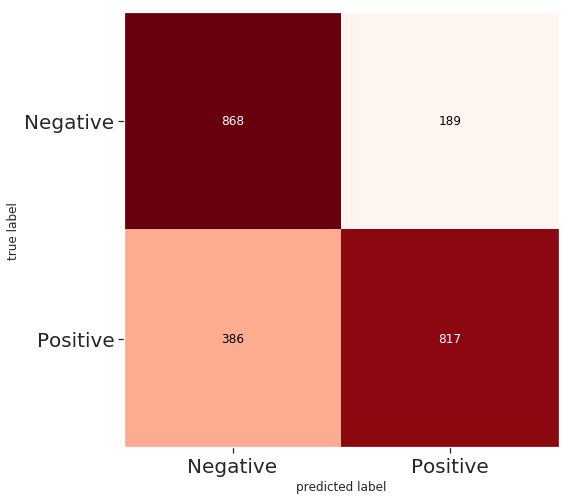

In [47]:
cm = confusion_matrix(y_test,y_pred_rf)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Reds)
plt.xticks(range(2), rf.classes_, fontsize=20)
plt.yticks(range(2), rf.classes_, fontsize=20)
plt.show()

**Predicting with Model**

In [48]:
k = random.randint(0,data.shape[0])
message = data['body_text'][k]
message

'3000 ka suit hai..pagal bna rhy hain..'

In [49]:
data['sentiment'][k]

'Negative'

In [50]:
predict_data = [message]
df = pd.DataFrame(predict_data,columns=['body_text'])
df['body_len'] = df['body_text'].apply(lambda x: len(x) - x.count(" "))
df['punct_count'] = df['body_text'].apply(lambda x: count_punct(x))
df['emoji_count'] = data['body_text'].apply(lambda x: count_emoji(x))

In [51]:
df

,body_text,body_len,punct_count,emoji_count
0,3000 ka suit hai..pagal bna rhy hain..,32,4,0


In [52]:
tfidf_predict = tfidf_vect_fit.transform(df['body_text'])
X_predict_vect = pd.concat([df[['body_len', 'punct_count','emoji_count']].reset_index(drop=True), 
           pd.DataFrame(tfidf_predict.toarray())], axis=1)

In [53]:
X_predict_vect

,body_len,punct_count,emoji_count,0,1,2,3,4,5,6,...,21913,21914,21915,21916,21917,21918,21919,21920,21921,21922
0,32,4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
rf_model.predict(X_predict_vect)

array(['Negative'], dtype=object)

References:

* [The Basics of Sentiment Analysis](https://monkeylearn.com/sentiment-analysis/)
* [Multiclass Classification Reporting and Interpretation](https://stackoverflow.com/questions/30746460/how-to-interpret-scikits-learn-confusion-matrix-and-classification-report)
* <a href ="https://8kmiles.com/blog/benchmarking-sentiment-analysis-systems/">Benchmarking Sentiment Analysis</a>
* <a href="https://www.lynda.com/Python-tutorials/NLP-Python-Machine-Learning-Essential-Training/622075-2.html">NLP with Python for Machine Learning - Lynda.com Course</a>
* <a href ="https://github.com/haseebelahi/roman-urdu-stopwords">Roman Urdu Stopwords</a>
* <a href="https://www.datacamp.com/community/tutorials/wordcloud-python">Wordcloud in Python</a>
* <a href="https://www.kaggle.com/parthsharma5795/comprehensive-twitter-airline-sentiment-analysis">Airline Twitter Sentiment Analysis</a>
* <a href="https://www.analyticsvidhya.com/blog/2018/07/hands-on-sentiment-analysis-dataset-python/">Hands on Guide to Twitter Sentiment Analysis</a>
* <a href="https://stackoverflow.com/questions/31421413/how-to-compute-precision-recall-accuracy-and-f1-score-for-the-multiclass-case">Stackoverflow</a>
* <a href="https://towardsdatascience.com/multi-class-metrics-made-simple-part-ii-the-f1-score-ebe8b2c2ca1">Multiclass Metric</a>